In [7]:
import pandas as pd
import numpy as np

In [8]:
df_deepgram = pd.read_csv('Deepgram_timit_results.csv')
df_fireworks = pd.read_csv('Fireworks_timit_results.csv')
df_openai = pd.read_csv('OpenAI_timit_results.csv')
df_whisperkit = pd.read_csv("WhisperKit_timit_results_non_casual.csv")

In [9]:
sources = {
    "deepgram": df_deepgram,
    "fireworks": df_fireworks,
    "openai": df_openai,
    "whisperkit": df_whisperkit
}
wer_l = {name: df['wer'].values for name, df in sources.items()}
global_wer = {name: df['wer_global'].values[-1] for name, df in sources.items()}

In [10]:
# Map system names to their row indices and DataFrames
systems = {
    "openai": (0, None),  # Placeholder for OpenAI with 0 values
    "deepgram": (1, df_deepgram),
    "fireworks": (2, df_fireworks),
    "whisperkit": (3, df_whisperkit)
}

# Columns correspond to deletion, substitution, insertion
metrics = ['number_deletions_global',  'number_insertions_global', 'number_substitutions_global',]

num_corrections_raw = np.zeros((4, 3))

for system, (row_idx, df) in systems.items():
    if df is None:
        continue  # OpenAI remains all zeros
    for col_idx, metric in enumerate(metrics):
        num_corrections_raw[row_idx, col_idx] = df[metric].values[-1]

/var/folders/zr/xmdvjztn7fn5d6f0pzv2110w0000gn/T/ipykernel_41867/3294030085.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


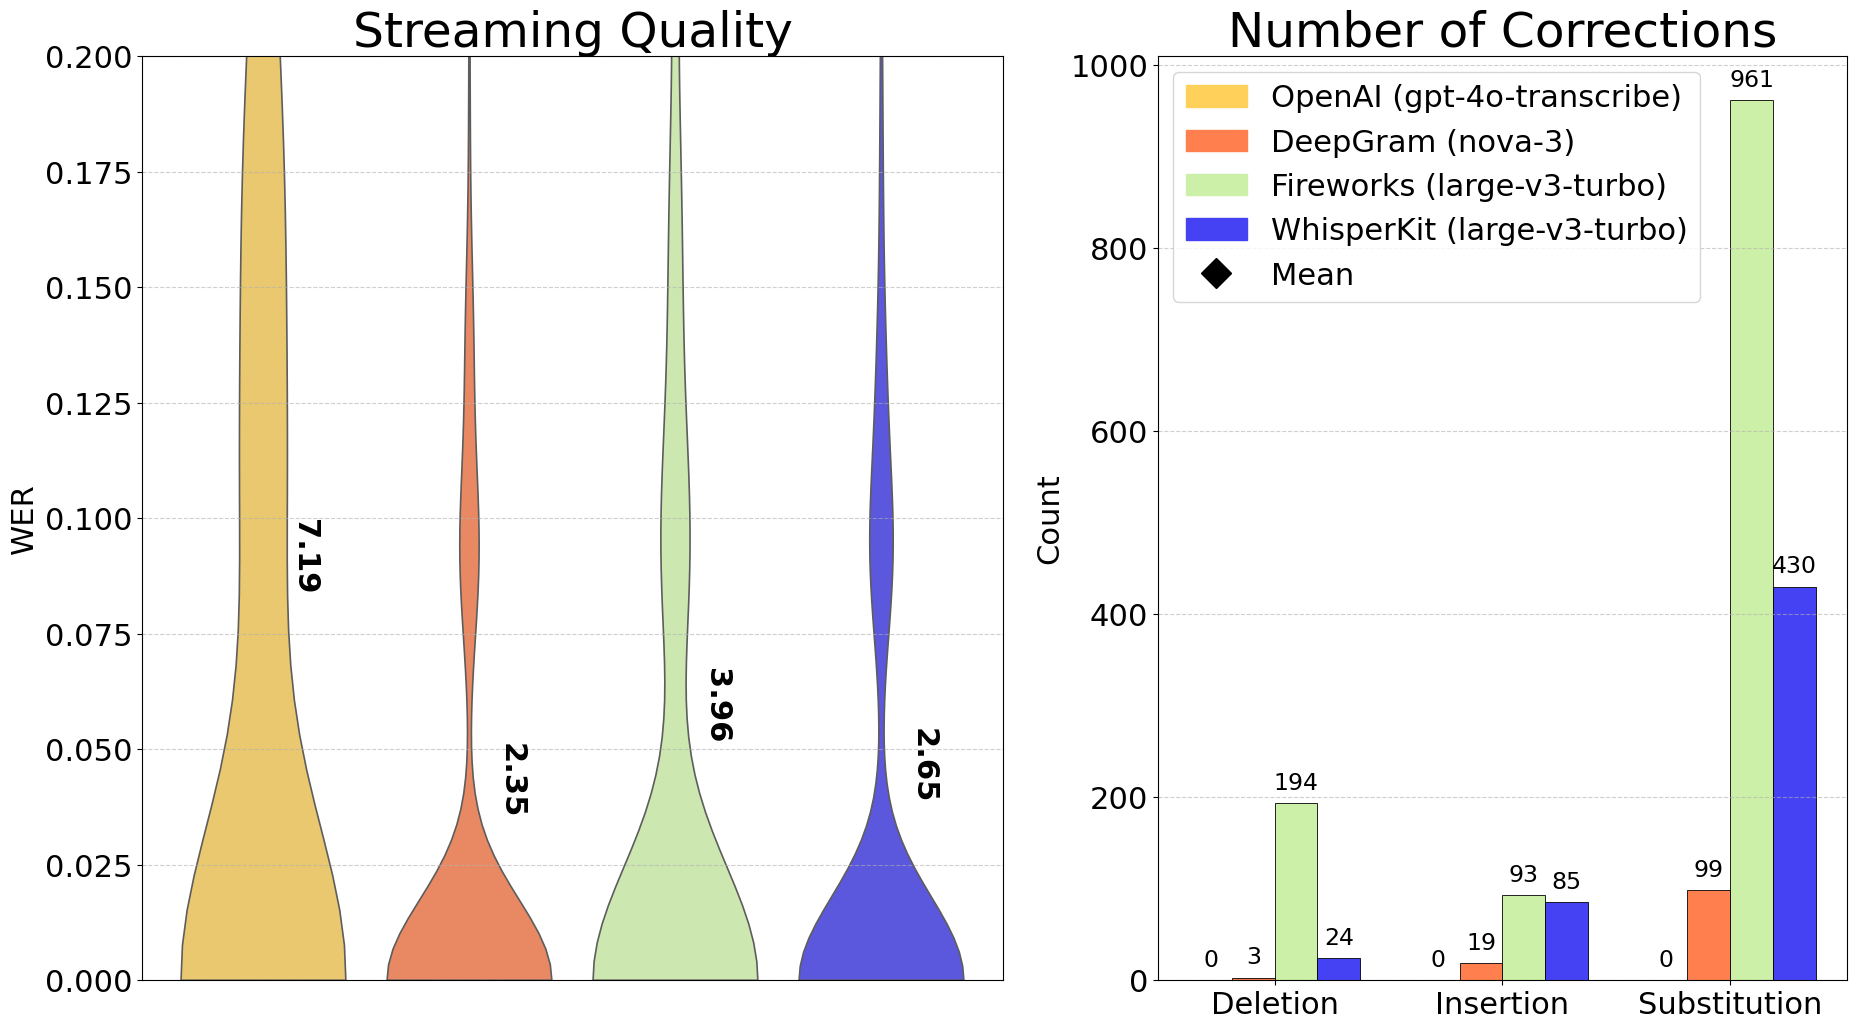

In [11]:
# ── Imports ───────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

labels  = [
    'OpenAI (gpt-4o-transcribe)',
    'DeepGram (nova-3)',
    'Fireworks (large-v3-turbo)',
    'WhisperKit (large-v3-turbo)',
]
colors  =  ['#FFD15A', '#FF7F4E', '#CCF0A7', '#4542F4']  
data    = [wer_l['openai'], wer_l['deepgram'], wer_l['fireworks'], wer_l['whisperkit']]
mean_val_l = [global_wer['openai'], global_wer['deepgram'], global_wer['fireworks'], global_wer['whisperkit']]

# ── DataFrame for Seaborn violinplot ───────────────────────────────────────────
df = pd.DataFrame({
    'Model': np.repeat(labels, [len(d) for d in data]),
    'WER':   np.concatenate(data)
})

# ── Create subplots ────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(22, 12),
    gridspec_kw={'width_ratios': [1, 0.8]}
)

# ── (a) Violin plot: Streaming Quality ────────────────────────────────────────
sns.violinplot(
    x='Model', y='WER', data=df, palette=colors,
    cut=0, inner=None, linewidth=1.2, ax=ax1
)

# Mean markers
for i, (d, color) in enumerate(zip(data, colors)):
    # mean_val = np.mean(d)* 100
    mean_val = mean_val_l[i]*100
    ax1.plot(i, mean_val, marker='D', color=color,
             markersize=15, markeredgewidth=1.5,
             markeredgecolor='white', zorder=3)
    ax1.text(i + 0.2, mean_val/100+0.02 , f'{mean_val:.2f}',
             ha='center', fontsize=22, color='black',
             rotation=270, va='center', fontweight ="bold")

# Styling
ax1.set_title('Streaming Quality', fontsize=35)
ax1.set_ylabel('WER', fontsize=22)
ax1.set_xlabel('')
ax1.set_ylim(0, 0.2)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', labelsize=22)
ax1.set_xticks([])

# Legend
model_handles = [Patch(color=c, label=lab) for c, lab in zip(colors, labels)]
mean_handle   = Line2D([0], [0], marker='D', color='black',
                       linestyle='None', markersize=15, label='Mean')

# ── (b) Bar plot: Number of Corrections  ──────────────────────────────────────
# ❶  Prepare the data ----------------------------------------------------------
systems = labels
error_labels = ['Deletion', 'Insertion', 'Substitution']          # group order
sys_colors   = ['#FFD15A', '#FF7F4E', '#CCF0A7', '#4542F4']       # per-system

# counts[system, error]  →  reorder columns to match error_labels
col_map = [0, 2, 1]                                               # D, I, S
counts  = num_corrections_raw.astype(np.int32)#[:, col_map]                                         # shape (4, 3)

# ❷  Plot bars grouped by *error type* -----------------------------------------
n_sys     = len(systems)
n_errors  = len(error_labels)
x         = np.arange(n_errors)                                   # centres of groups
bar_w     = 0.75 / n_sys                                          # total width ≈0.75
offsets   = (np.arange(n_sys) - (n_sys-1)/2) * bar_w              # left-to-right shifts

for i, (sys, col) in enumerate(zip(systems, sys_colors)):
    ax2.bar(x + offsets[i], counts[i], bar_w,
            label=sys, color=col, edgecolor='black', linewidth=0.6)

# ❸  Cosmetics -----------------------------------------------------------------
ax2.set_xticks(x)
ax2.set_xticklabels(error_labels, fontsize=22)
ax2.set_ylabel('Count', fontsize=22)
ax2.set_title('Number of Corrections', fontsize=35)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# legend is now *systems* instead of error types
ax2.legend(handles=model_handles + [mean_handle],
           fontsize=22, loc='upper left')

# annotate each bar
for i_sys in range(n_sys):
    for i_err in range(n_errors):
        y = counts[i_sys, i_err]
        ax2.text(x[i_err] + offsets[i_sys],
                 y + max(counts.flat)*0.01,
                 str(y), ha='center', va='bottom', fontsize=17)

for lab in ax2.get_yticklabels():
    lab.set_fontsize(22)


In [12]:
# Define the systems and associated DataFrames (None for OpenAI streaming global as special case)
systems = {
    "deepgram": df_deepgram,
    "fireworks": df_fireworks,
    "openai": df_openai,
    "whisperkit": df_whisperkit
}

# Initialize dictionaries for values
streaming = {}
global_streaming = {}
confirmed_streaming = {}
global_confirmed_streaming = {}

for name, df in systems.items():
    streaming[name] = df['streaming_latency'].values
    confirmed_streaming[name] = df['confirmed_streaming_latency'].values

    # Handle OpenAI special case for global streaming latency
    if name == "openai":
        global_streaming[name] = 0
    else:
        global_streaming[name] = df['streaming_latency_global'].values[-1]

    global_confirmed_streaming[name] = df['confirmed_streaming_latency_global'].values[-1]

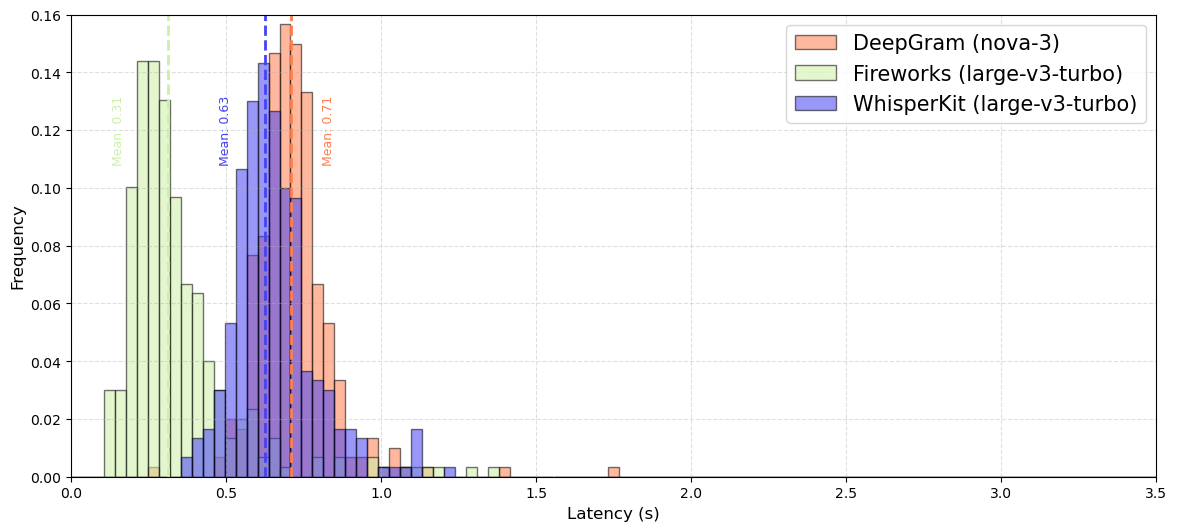

In [13]:
# ── Imports ────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np

def filter_valid_latencies(min_l, max_l):
    """Replace negative latencies by 0 and return cleaned arrays."""
    min_l = np.array(min_l, dtype=float)
    max_l = np.array(max_l, dtype=float)
    min_l[min_l < 0] = 0
    max_l[max_l < 0] = 0
    return min_l, max_l


# ── Helper to build a single normalised-histogram panel ─────────────────────
def add_latency_histogram(ax, gt_avg, gt_global, *, title, legend):
    """Draw one normalised-histogram panel on the given Axes."""

    # | plotting parameters
    if legend:
        colors  = [ '#FF7F4E', '#CCF0A7', '#4542F4']
        labels  = [

            'DeepGram (nova-3)',
            'Fireworks (large-v3-turbo)',
            'WhisperKit (large-v3-turbo)'
        ]
        offsets = [0.1, -0.18, -0.15, 0.05]         # tweak ↔ mean-label positions
        y_offset = 0.12
    else:
        colors  = ['#FFD15A', '#FF7F4E', '#4542F4']
        labels  = [
            'OpenAI (gpt-4o-transcribe)',
            'DeepGram (nova-3)',
            'WhisperKit (large-v3-turbo)',
        ]
        offsets = [0.05, -0.12, -0.2] 
        y_offset = 0.09
        
    bins    = np.linspace(0, 3.5, 100)
    i =0 
    # 3 | histograms (each ∑bin = 1)
    for d, c, lab, off in zip(gt_avg, colors, labels, offsets):
        counts, edges = np.histogram(d, bins=bins)
        rel_freq      = counts / counts.sum() if counts.sum() else counts
        centers       = (edges[:-1] + edges[1:]) / 2
        ax.bar(centers, rel_freq, width=np.diff(edges),
               alpha=0.55, edgecolor='black', color=c, label=lab)

        mean_val = np.mean(d)
        ax.axvline(gt_global[i], color=c, linestyle='dashed', linewidth=2)
        ax.text(gt_global[i] + off, y_offset, f'Mean: {gt_global[i]:.2f}',
                color=c, fontsize=9, rotation=90, va='center')
        i+=1

    # 4 | cosmetics
    ax.set_title(title, fontsize=15)
    ax.set_xlim(0, 3.5)
    ax.set_ylim(0, 0.16)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_xlabel('Latency (s)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.tick_params(labelsize=10) 
    ax.legend(fontsize=15)
        

# ── Build the two-panel figure ──────────────────────────────────────────────
fig, ax_a = plt.subplots(1, 1, figsize=(14, 6), sharey=True,
                                 gridspec_kw={'wspace': 0.25})

# (a) original data
add_latency_histogram(
    ax_a,
    gt_avg=[
            streaming['deepgram'],
            streaming['fireworks'],
            streaming['whisperkit']
        ],
    gt_global=[
            global_streaming['deepgram'],
            global_streaming['fireworks'],
            global_streaming['whisperkit']
        ],
    title='',
    legend = True
)




/var/folders/zr/xmdvjztn7fn5d6f0pzv2110w0000gn/T/ipykernel_41867/1600540334.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


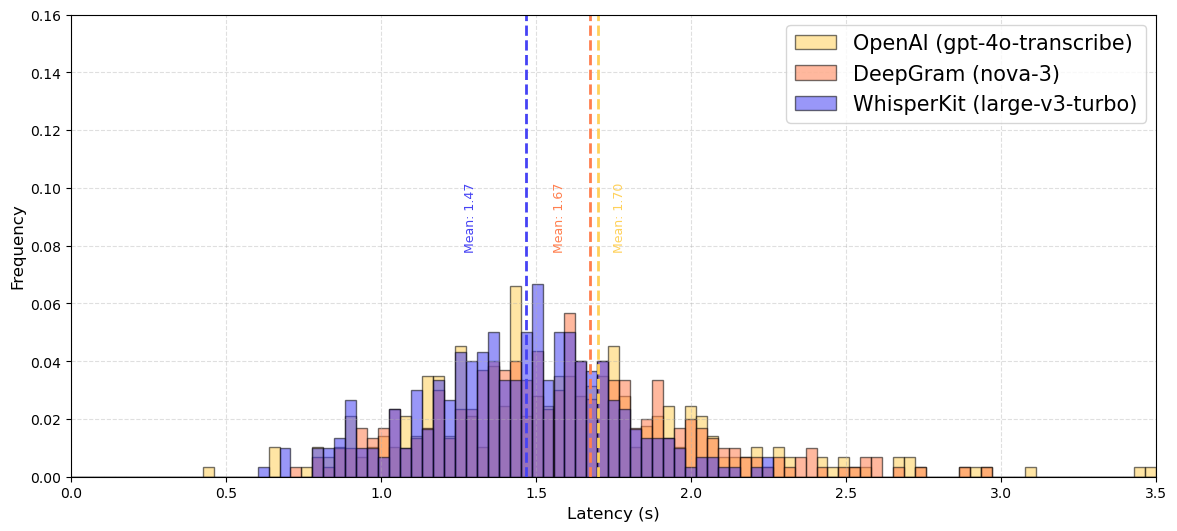

In [14]:
fig, ax_b = plt.subplots(1, 1, figsize=(14, 6), sharey=True,
                                 gridspec_kw={'wspace': 0.25})
# (b) confirmed data
add_latency_histogram(
    ax_b,
    gt_avg=[
            confirmed_streaming['openai'],
            confirmed_streaming['deepgram'],
            confirmed_streaming['whisperkit']
        ],
     gt_global=[
            global_confirmed_streaming['openai'],
            global_confirmed_streaming['deepgram'],
            global_confirmed_streaming['whisperkit']
        ],
    title='',
    legend = False
)


plt.tight_layout()
plt.show()